<a href="https://colab.research.google.com/github/i-zeeshan-afzal/Deep-Learning/blob/main/week8_YOLO12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [1]:
!nvidia-smi

Mon Oct 20 14:07:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

## Install YOLO12


YOLO12 can be installed via pip.

In [19]:
!pip install ultralytics albumentations roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [3]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.5/112.6 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started.

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [5]:
%cd {HOME}
!yolo task=detect mode=predict model=yolo12n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

[Errno 2] No such file or directory: '{HOME}'
/content
Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,590,824 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 2 dogs, 88.5ms
Speed: 8.8ms preprocess, 88.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


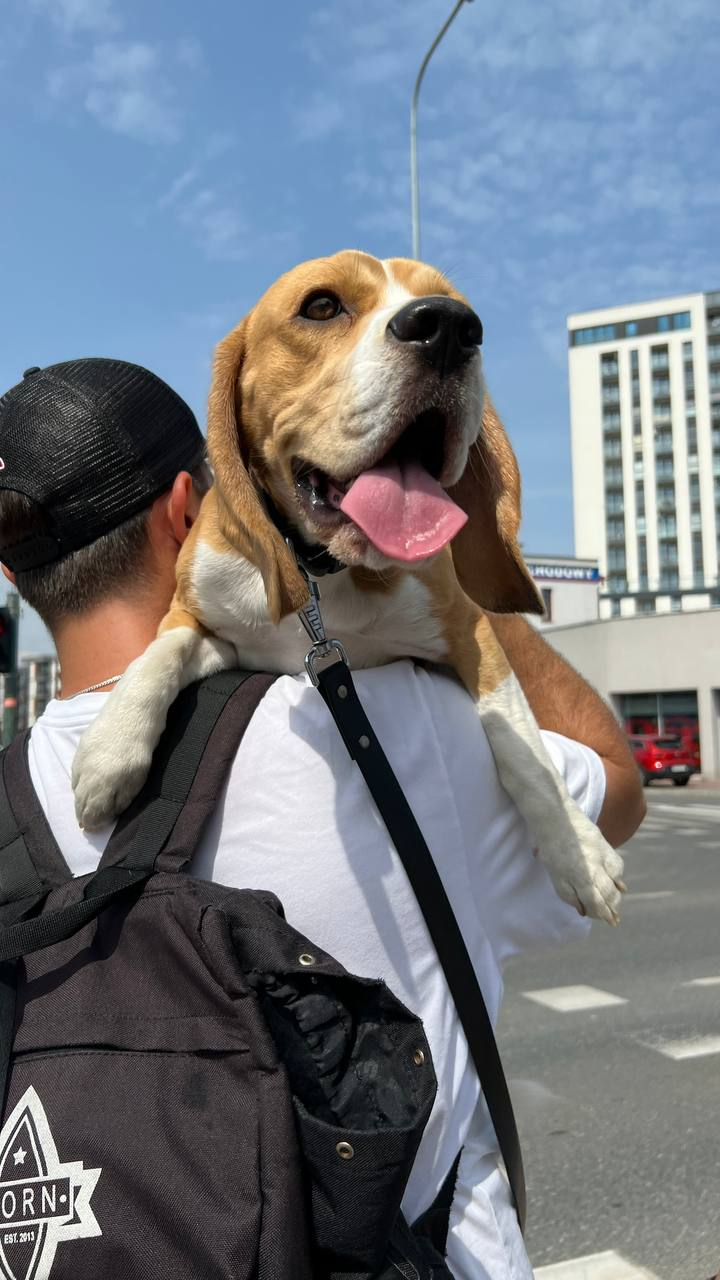

In [12]:
Image(filename='dog.jpeg', height=600)

In [9]:
!ls {HOME}/runs/detect/predict

dog.jpeg  runs	yolo12n.pt


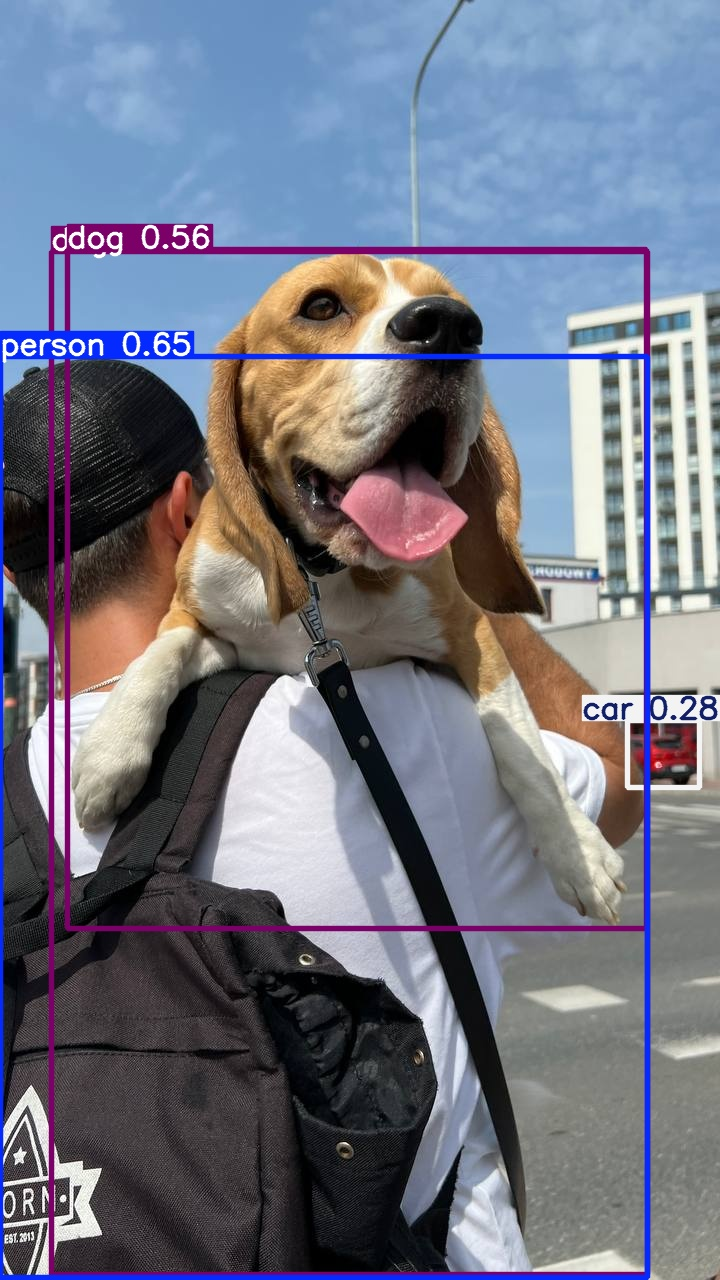

In [14]:
Image(filename=f'runs/detect/predict/dog.jpg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [15]:
model = YOLO('yolo12n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 2 dogs, 82.1ms
Speed: 2.0ms preprocess, 82.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 384)


In [16]:
results[0].boxes.xyxy

tensor([[2.4017e-01, 3.5632e+02, 6.4733e+02, 1.2772e+03],
        [6.7411e+01, 2.4999e+02, 6.4616e+02, 9.2832e+02],
        [5.1985e+01, 2.5119e+02, 6.4709e+02, 1.2750e+03],
        [6.2767e+02, 7.2025e+02, 6.9907e+02, 7.8794e+02]], device='cuda:0')

In [17]:
results[0].boxes.conf

tensor([0.6469, 0.5572, 0.5153, 0.2773], device='cuda:0')

In [18]:
results[0].boxes.cls

tensor([ 0., 16., 16.,  2.], device='cuda:0')

## Preparing a custom dataset

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `desired` dataset format.

<div align="center">
  <img
    width="640"
    src="https://ik.imagekit.io/roboflow/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




To be more specific:
- Download the dataset from the provided link: [Automated Detection and Quantification of Contact Behaviour in Pigs Dataset](https://salford.figshare.com/articles/dataset/Automated_detection_and_quantification_of_contact_behaviour_in_pigs_using_deep_learning/21346767)
- Extract the downloaded dataset and locate the folder that contains the pig parts detection with any type of annotation. This folder will be used for further processing.
- Create an account with Roboflow if you don't have one already. Roboflow is a platform that helps in preparing and managing datasets for computer vision tasks.
- Once logged in to Roboflow, create a new object detection project by selecting the appropriate option from the project creation menu.
- Follow the instructions to set up the project and select the folder containing the dataset that you extracted in step 2. Upload the dataset to Roboflow and wait for the upload process to complete.
- After the dataset is uploaded, you can choose to split the dataset into training, validating and testing sets (code will not work if not all three are available) based on your requirements. Follow the provided options and instructions to perform the split and wait for the process to complete.
- Once the dataset is split, you will be presented with several steps. Click "Continue" on each step without applying any preprocessing or augmentation. These steps are optional and can be used to preprocess and augment the dataset if required. For this exercise, we will skip them.
- Finally, click "Generate Dataset" to proceed. On the following page, you will find an option to export the dataset. Choose the export format suitable for YOLOv7 and select "Show Download Code" to obtain the code needed for downloading the dataset.
- Copy the provided code, which may include commands or scripts, and use it to download the exported dataset. Ensure that you have the necessary dependencies, such as PyTorch, installed to run YOLOv8 on the downloaded dataset.
By following these steps, students can obtain an object detection dataset in the appropriate format for running YOLOv8 using the Roboflow platform and the provided dataset.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets


from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("YOUR-WORKSPACE").project("YOUR-PROJECT")
dataset = project.version(3).download("yolo12")

## Custom Training
##### increase the number of epochs for better precision

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo12s.pt data={dataset.location}/data.yaml epochs=1 imgsz=800 plots=True

In [ ]:
!ls {HOME}/runs/detect/train/

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

**NOTE:** Let's take a look at few results.

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")